<a href="https://www.kaggle.com/code/klyushnik/xgbclassifier-setting?scriptVersionId=168293864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv
/kaggle/input/reservation-cancellation-prediction/train__dataset.csv
/kaggle/input/reservation-cancellation-prediction/test___dataset.csv


# **Loading data**

In [2]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e7/train.csv')
train_org = pd.read_csv('/kaggle/input/reservation-cancellation-prediction/test___dataset.csv')

# **Start data processing**

In [3]:
train_all = pd.concat([train, train_org]).reset_index(drop=True)

train_all = train_all.drop(columns =['id'])
test = test.drop(columns =['id'])

train_all = train_all.fillna(0)

* **Remove uncharacteristic data, get list_columns**

In [4]:
list_columns = train_all.columns
list_columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status'],
      dtype='object')

* **Use quantile**

In [5]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
outlier_list = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status']
for  i in outlier_list:
    outlier_removal(train_all ,i)

* **Library downloads**

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# **Split the dataset into training and test**

In [7]:
from sklearn.model_selection import train_test_split

X = train_all.drop(columns = ['booking_status'])
y = train_all.booking_status

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.45, random_state=42)

# **XGBClassifier**

* **From sklearn.model_selection import GridSearchCV import lightgbm as lgb from tqdm import tqdm from sklearn.metrics import (roc_curve, auc, accuracy_score)**

In [8]:
from sklearn.model_selection import  GridSearchCV
from xgboost import XGBClassifier
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import (roc_curve, auc, accuracy_score)

* **Use GridSearchCV**

In [9]:
'''estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X, y)

grid_search.best_estimator_'''

"estimator = XGBClassifier(\n    objective= 'binary:logistic',\n    nthread=4,\n    seed=42\n)\n\nparameters = {\n    'max_depth': range (2, 10, 1),\n    'n_estimators': range(60, 220, 40),\n    'learning_rate': [0.1, 0.01, 0.05]\n}\n\ngrid_search = GridSearchCV(\n    estimator=estimator,\n    param_grid=parameters,\n    scoring = 'roc_auc',\n    n_jobs = 10,\n    cv = 10,\n    verbose=True\n)\n\ngrid_search.fit(X, y)\n\ngrid_search.best_estimator_"

* **Set parametrs**

In [10]:
'''gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [200],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(X, y)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)'''

"gridParams = {\n    'learning_rate': [0.005, 0.01],\n    'n_estimators': [200],\n    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting\n    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart\n    'objective' : ['binary'],\n    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress\n    'random_state' : [500],\n    'colsample_bytree' : [0.64, 0.65, 0.66],\n    'subsample' : [0.7,0.75],\n    'reg_alpha' : [1,1.2],\n    'reg_lambda' : [1,1.2,1.4],\n    }\n\ngrid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)\n# Run the grid\ngrid.fit(X, y)\n\n# Print the best parameters found\nprint(grid.best_params_)\nprint(grid.best_score_)"

* **grid.best_params_**

In [11]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=200,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, objective= 'binary:logistic',seed=42)

clf.fit(X_train,y_train)

pred = clf.predict_proba(X_test)[:,1]

* **Let's make a graph**

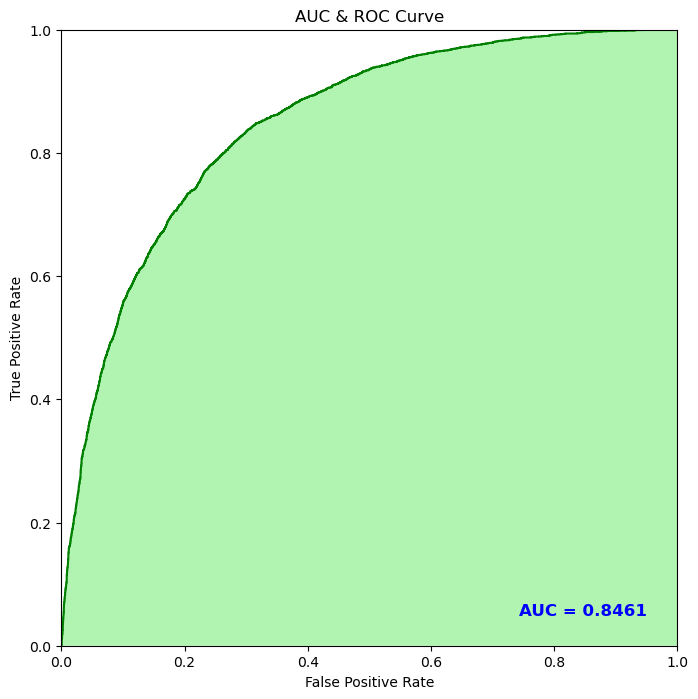

In [12]:
auc = metrics.roc_auc_score(y_test, pred)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# **Making predictions**

In [13]:
y_pred = clf.predict_proba(test)[:, 1]
sub['booking_status'] = y_pred

In [14]:
sub.to_csv('submission.csv', index=False)